In [1]:
!pip uninstall -y -q yellowbrick

!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
!pip install -q opencv-python==3.4.5.20
!pip install -q numpy==1.20.0
!pip install -q cellpose 
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not find a version that satisfies the requirement opencv-python==3.4.5.20 (from versions: 3.4.0.14, 3.4.8.29, 3.4.9.31, 3.4.9.33, 3.4.10.35, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.14.53, 3.4.15.55, 3.4.16.57, 3.4.16.59, 4.1.2.30, 4.2.0.32, 4.2.0.34, 4.3.0.36, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.2.54, 4.5.3.56, 4.5.4.58, 4.5.4.60)
ERROR: No matching distribution found for opencv-python==3.4.5.20
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import glob

from tqdm.auto import tqdm
import tifffile
import matplotlib.pyplot as plt
import random

## Visualising Flows
#### 5-fold data Generated in cellpose format here: https://www.kaggle.com/ks2019/sartorius-train-tif

In [3]:
HOME = os.path.join('/home/ubuntu/kaggle-sartorius/')
RAW_DATA = os.path.join(HOME,'data/raw')
INTERIM_DATA = os.path.join(HOME,'data/interim')
PROCESSED_DATA = os.path.join(HOME,'data/processed')

TRAIN_CSV  = os.path.join(RAW_DATA,'train.csv')  
TRAIN_PATH = os.path.join(RAW_DATA,'train')  
TEST_PATH  = os.path.join(RAW_DATA,'test')  
MODELS_PATH = os.path.join(HOME,'models')
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = MODELS_PATH

619f91a5c197_img.tif


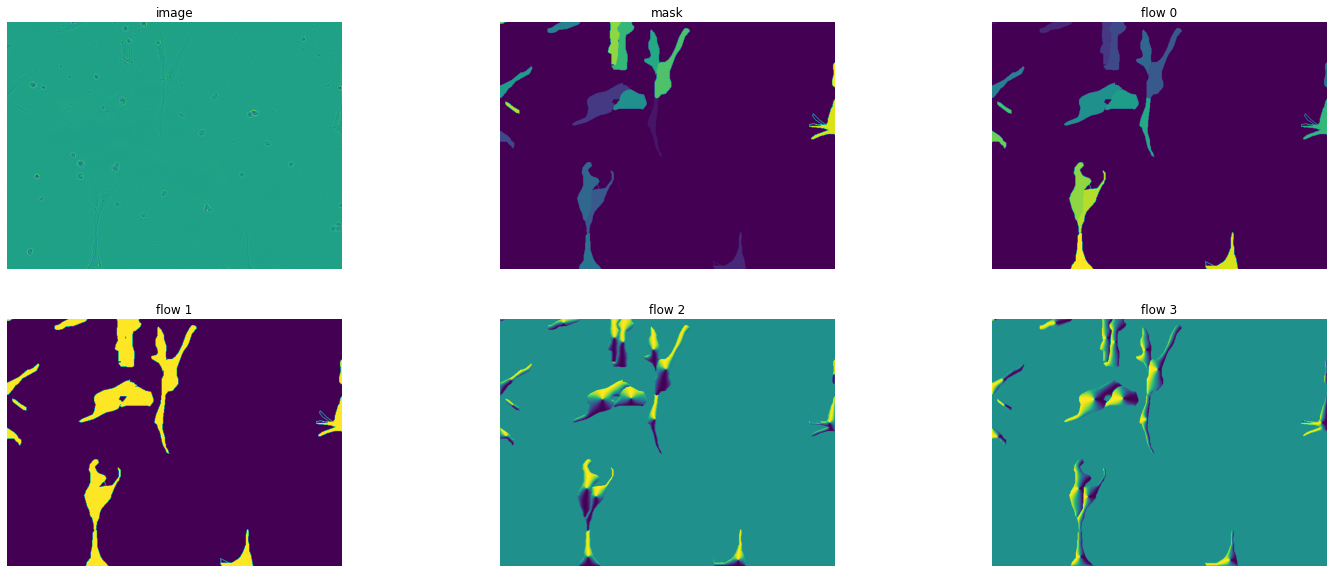

ee6ddcdc19ce_img.tif


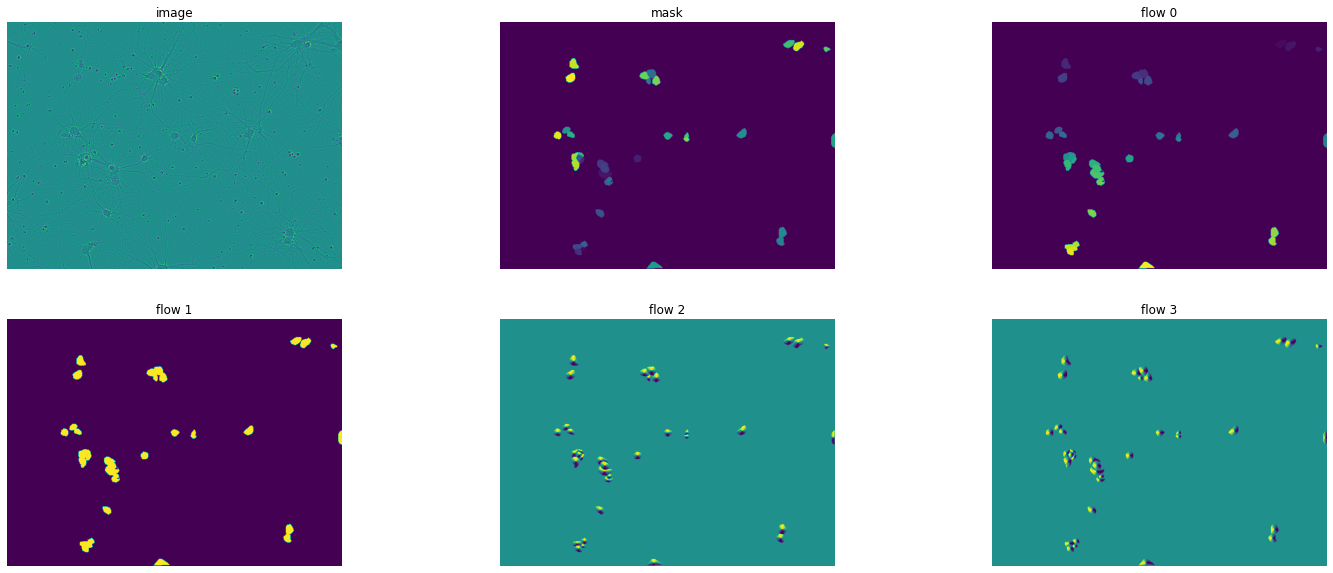

0ba181d412da_img.tif


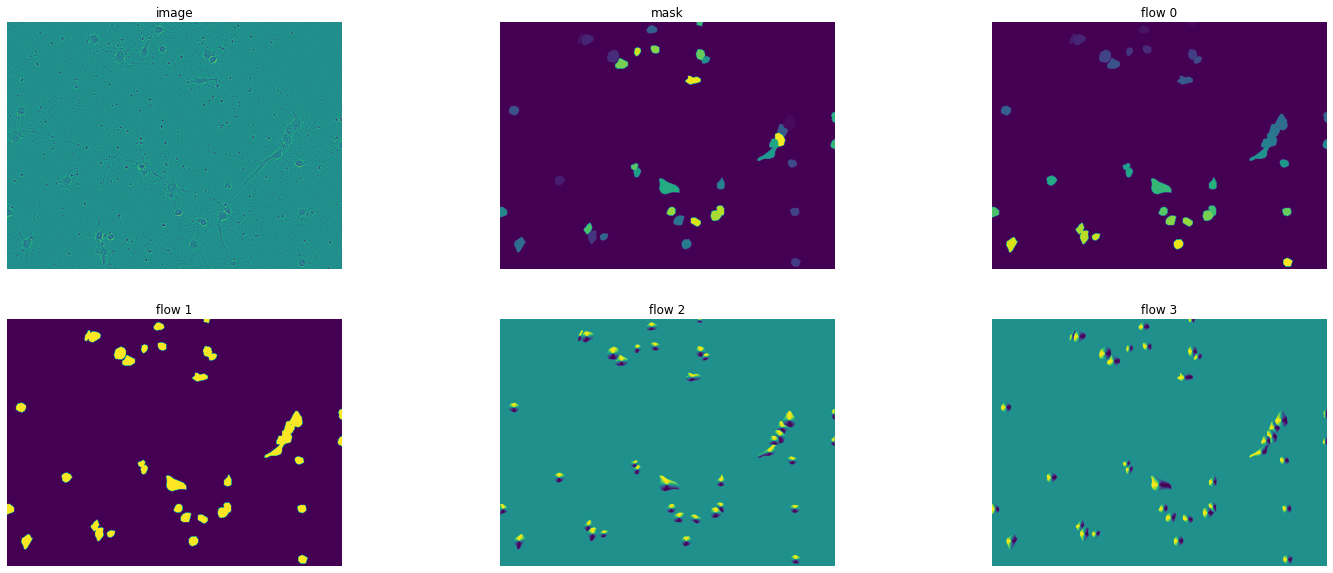

9ae06a9d5011_img.tif


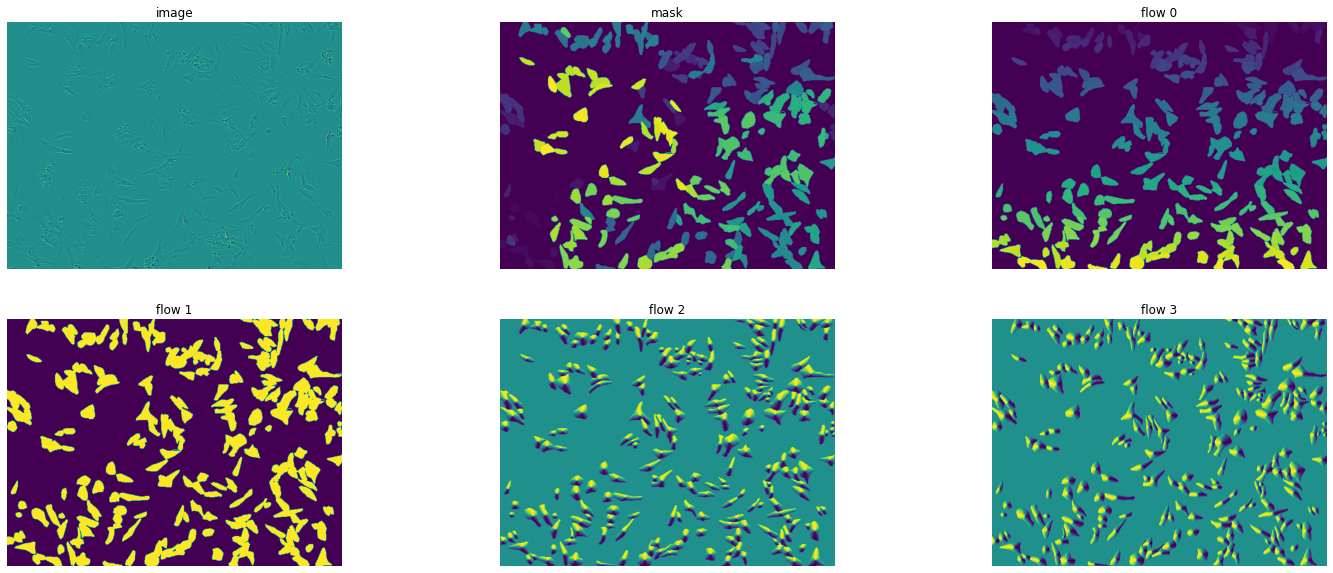

7f21996da2e6_img.tif


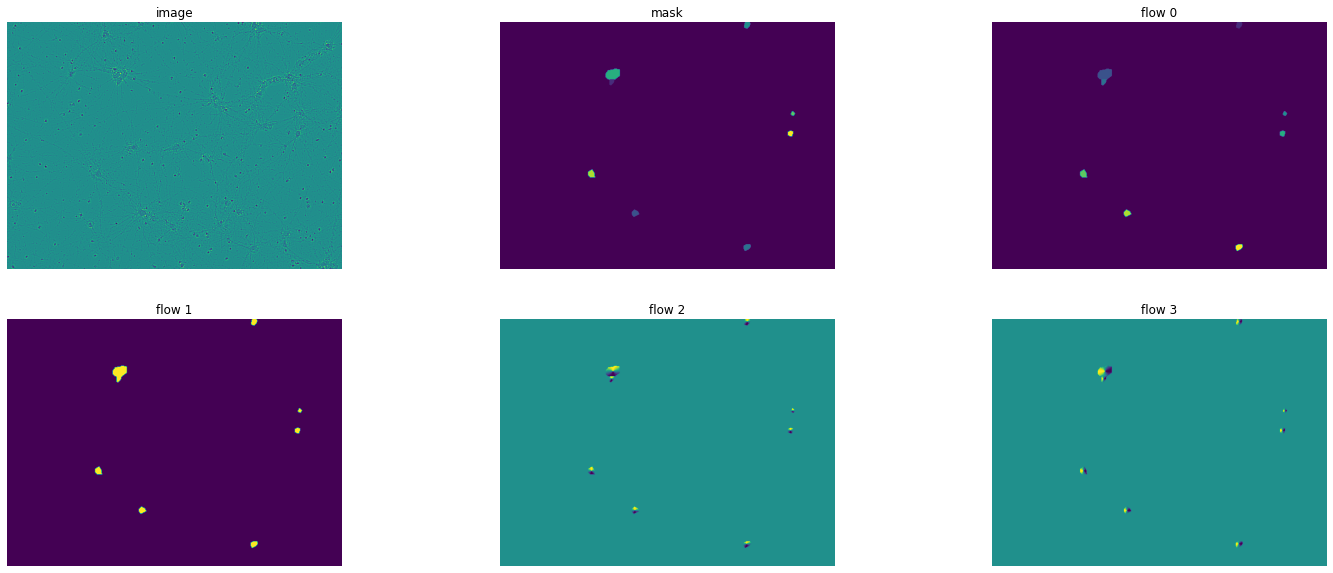

In [4]:
def plot_example(img_path):
    mask_path = img_path.replace('img','masks')
    flow_path = img_path.replace('img','flows')
    img = tifffile.imread(img_path)
    masks = tifffile.imread(mask_path)
    flows = tifffile.imread(flow_path)

    plt.figure(figsize=(25,10))
    plt.subplot(2,3,1)
    plt.axis('off')
    plt.imshow(img)
    plt.title('image')
    plt.subplot(2,3,2)
    plt.axis('off')
    plt.imshow(masks)
    plt.title('mask')
    for k in range(4):
        plt.subplot(2,3,3+k)
        plt.axis('off')
        plt.imshow(flows[k])
        plt.title(f'flow {k}')
    plt.show()
    
root = os.path.join(RAW_DATA,'sartorius-train-tif','fold_0','train/') 
sample_paths = os.listdir(root)
sample_paths = [x for x in sample_paths if 'img' in x]
random.shuffle(sample_paths)
for k in range(5):
    img_path = sample_paths[k]
    print(img_path)
    plot_example(root+img_path)

## Train

In [5]:
model_to_load = 'cyto' ## cyto, cyto2, nuclei
number_of_epochs = 10  ## Train more epochs for better results
batch_size = 8
initial_learning_rate = 0.0002
Training_channel = 0 # For grayscale
Second_training_channel= 0 
train_folder = '/tmp/cellpose_train/train'
test_folder = '/tmp/cellpose_train/val'
FOLD = 2

In [6]:
!rm -rf /tmp

rm: cannot remove '/tmp/systemd-private-d83de7219b1c4effa908ec1cf9ee984f-systemd-resolved.service-pxoqsj': Operation not permitted
rm: cannot remove '/tmp/.ICE-unix': Operation not permitted
rm: cannot remove '/tmp/systemd-private-d83de7219b1c4effa908ec1cf9ee984f-systemd-timesyncd.service-lb2jsg': Operation not permitted
rm: cannot remove '/tmp/.XIM-unix': Operation not permitted
rm: cannot remove '/tmp/.X11-unix': Operation not permitted
rm: cannot remove '/tmp/systemd-private-d83de7219b1c4effa908ec1cf9ee984f-systemd-logind.service-qp86jf': Operation not permitted
rm: cannot remove '/tmp/.Test-unix': Operation not permitted
rm: cannot remove '/tmp/.font-unix': Operation not permitted
rm: cannot remove '/tmp/snap.lxd': Operation not permitted
rm: cannot remove '/tmp/glances-root.log': Operation not permitted


In [7]:
!mkdir -p /tmp/cellpose_train/

root = os.path.join(RAW_DATA,'sartorius-train-tif')
!cp -r {root}/fold_{FOLD}/* /tmp/cellpose_train/

In [8]:
!ls {train_folder} | wc -l
!ls {test_folder} | wc -l

1455
363


In [10]:
!python -m cellpose \
        --train \
        --use_gpu \
        --fast_mode \
        --dir "$train_folder" --test_dir "$test_folder" \
        --pretrained_model $model_to_load \
        --chan $Training_channel --chan2 $Second_training_channel \
        --n_epochs $number_of_epochs \
        --learning_rate $initial_learning_rate \
        --batch_size $batch_size \
        --img_filter img \
        --mask_filter masks

creating new log file
2021-12-27 13:47:06,127 [INFO] WRITING LOG OUTPUT TO /home/ubuntu/.cellpose/run.log
2021-12-27 13:47:09,133 [INFO] ** TORCH CUDA version installed and working. **
2021-12-27 13:47:09,133 [INFO] >>>> using GPU
2021-12-27 13:47:09,134 [INFO] Downloading: "https://www.cellpose.org/models/cytotorch_0" to /home/ubuntu/kaggle-sartorius/models/cytotorch_0

100%|██████████████████████████████████████| 25.3M/25.3M [00:00<00:00, 50.0MB/s]
Not all flows are present. Run flow generation again.
Not all flows are present. Run flow generation again.
2021-12-27 13:47:10,483 [INFO] >>>> pretrained model /home/ubuntu/kaggle-sartorius/models/cytotorch_0 is being used
2021-12-27 13:47:10,483 [INFO] >>>> during training rescaling images to fixed diameter of 30.0 pixels
2021-12-27 13:47:10,626 [INFO] Training with rescale = 1.00
2021-12-27 13:47:14,795 [INFO] train channels = 2
2021-12-27 13:47:15,842 [INFO] test channels = 2
2021-12-27 13:47:15,843 [INFO] NOTE: computing flows for lab

In [11]:
!ls -lh /tmp/cellpose_train/train/models

total 26M
-rw-r--r-- 1 ubuntu ubuntu 26M Dec 27 13:50 cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_13_49_29.004444


In [12]:
!cp -r /tmp/cellpose_train/train/models .

## Inference 

Refer: https://www.kaggle.com/slawekbiel/cellpose-inference-307-lb

In [13]:
model_path = glob.glob('models/*')[0]
print(model_path)

models/cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_13_49_29.004444


In [17]:
%%writefile predict.py
import sys
import numpy as np
from cellpose import models, io, plot
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import glob

USE_GPU_FOR_INFERENCE = True

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

test_files = glob.glob('/tmp/cellpose_train/val/*_img.tif')
print(len(test_files))
model = models.CellposeModel(gpu=USE_GPU_FOR_INFERENCE, pretrained_model=sys.argv[1])

ids, masks = [],[]
for fn in tqdm(test_files):
    id_ = fn.split('/')[-1].replace('_img.tif','')
    preds, flows, _ = model.eval(io.imread(fn), diameter=19, channels=[0,0], augment=True, resample=True)
    for i in range (1, preds.max() + 1):
        ids.append(id_)
        masks.append(rle_encode(preds == i))
        
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('val_predictions.csv', index=False)

Overwriting predict.py


In [18]:
!python predict.py {model_path} /tmp/cellpose_train/val

2021-12-27 13:51:59,894 [INFO] WRITING LOG OUTPUT TO /home/ubuntu/.cellpose/run.log
121
2021-12-27 13:52:00,023 [INFO] parsing model string cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_13_49_29.004444 to get cellpose options
2021-12-27 13:52:01,252 [INFO] ** TORCH CUDA version installed and working. **
2021-12-27 13:52:01,253 [INFO] >>>> using GPU
100%|█████████████████████████████████████████| 121/121 [01:48<00:00,  1.11it/s]


## Plot

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import skimage
import skimage.segmentation
import matplotlib.pyplot as plt

In [20]:
def rles_to_mask(encs, shape):
    """
    Decodes a rle.

    Args:
        encs (list of str): Rles for each class.
        shape (tuple [2]): Mask size.

    Returns:
        np array [shape]: Mask.
    """
    img = np.zeros(shape[0] * shape[1], dtype=np.uint)
    if type(encs)==float:
        return img
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape)

'/home/ubuntu/kaggle-sartorius/data/raw/train.csv'

In [22]:
width = 704
height = 520
shape = [height,width]

train_df = pd.read_csv(TRAIN_CSV)
train_df = train_df.groupby('id').annotation.agg(list).reset_index()

cellpose_predictions = pd.read_csv('val_predictions.csv')
cellpose_predictions = cellpose_predictions.groupby('id').predicted.agg(list).reset_index()
df = pd.merge(train_df,cellpose_predictions,on='id')

print(df.shape)

df.sample(2)

(121, 3)


,id,annotation,predicted
106,e201f565a7d8,[260210 1 260913 3 261615 6 262317 8 263020 10...,[10294 3 10996 8 11698 12 12401 14 13104 16 13...
12,22e0c43da285,[353054 3 353756 9 354458 13 355162 14 355866 ...,[31862 4 32566 4 33269 5 33973 5 34676 6 35380...


029e5b3b89c7


<ipython-input-20-f92e87a23207>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(enc, np.float) and np.isnan(enc):


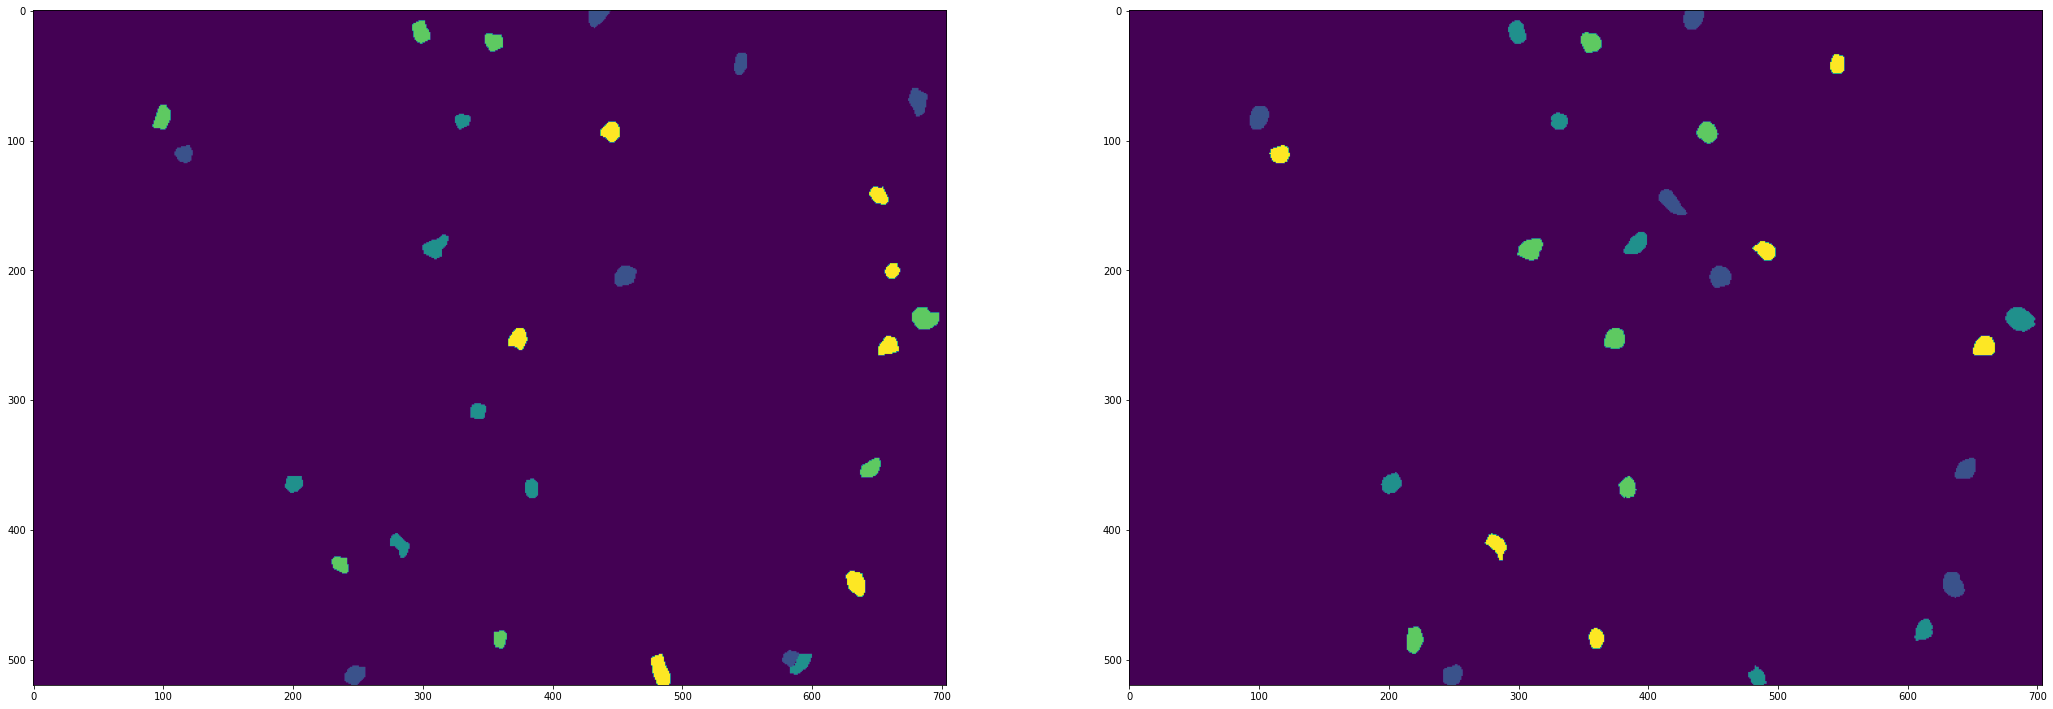

0323e81d23d9


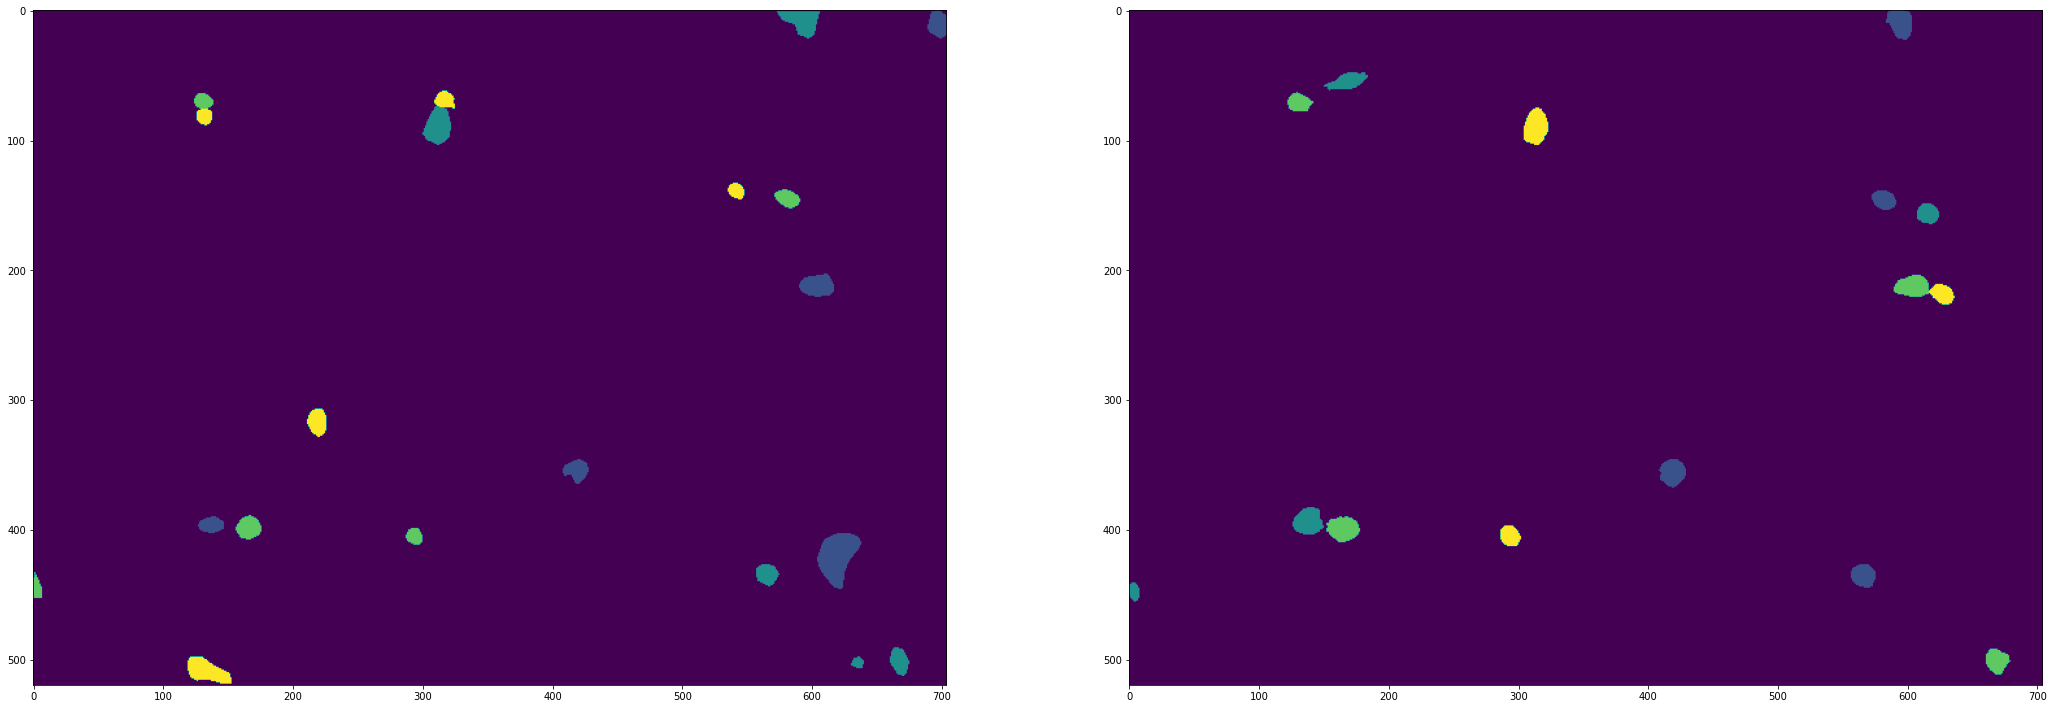

049f02e0f764


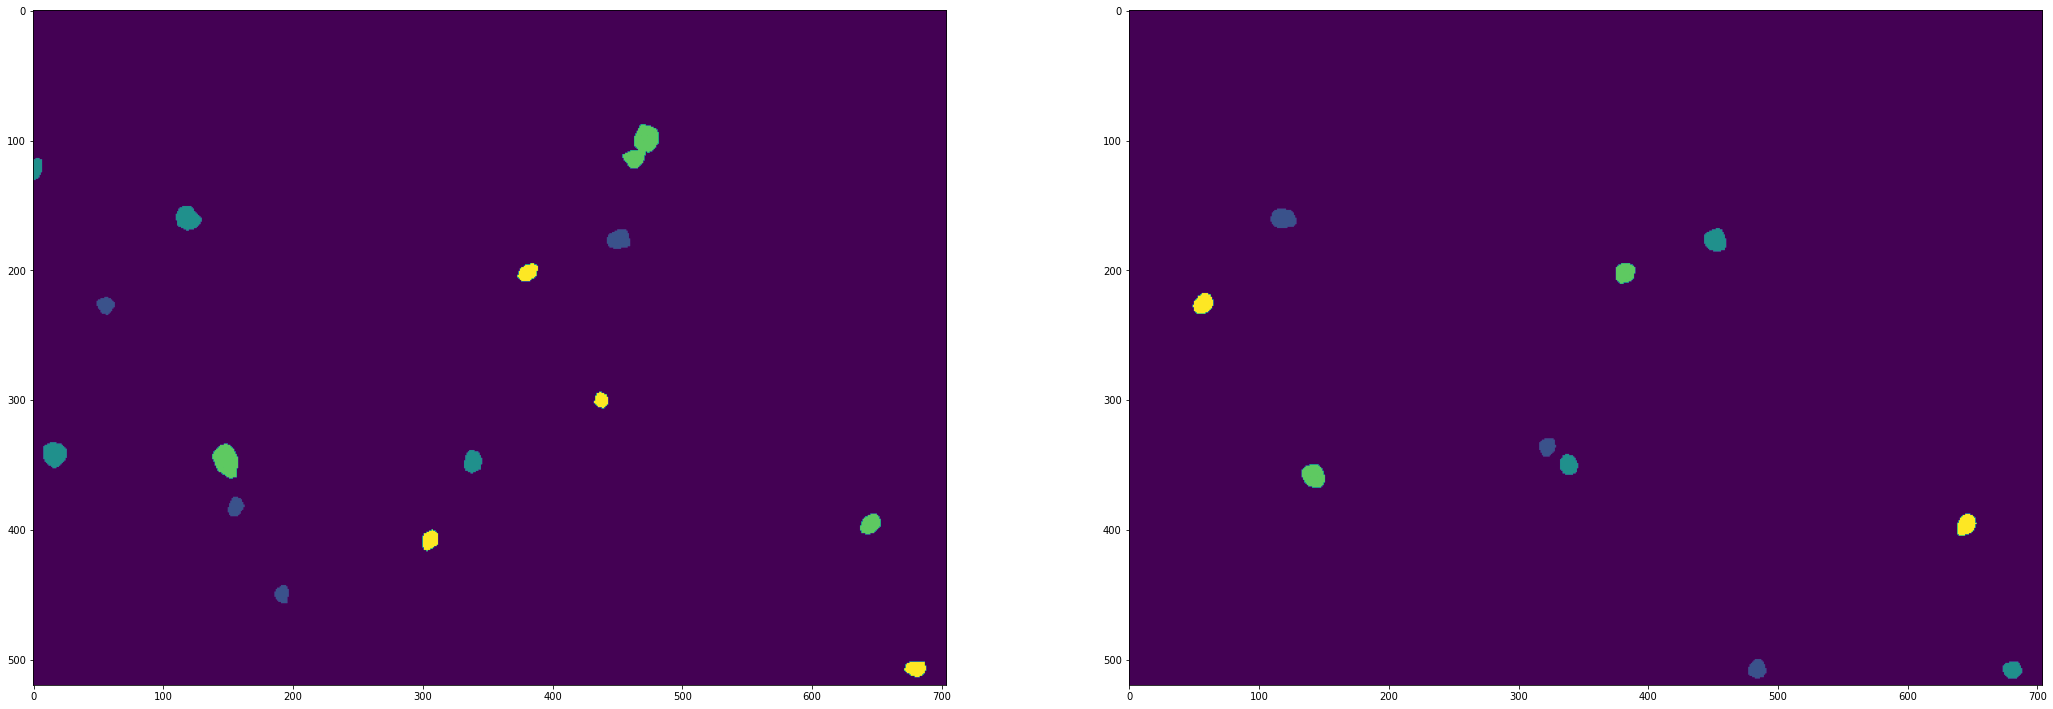

0728b8f39241


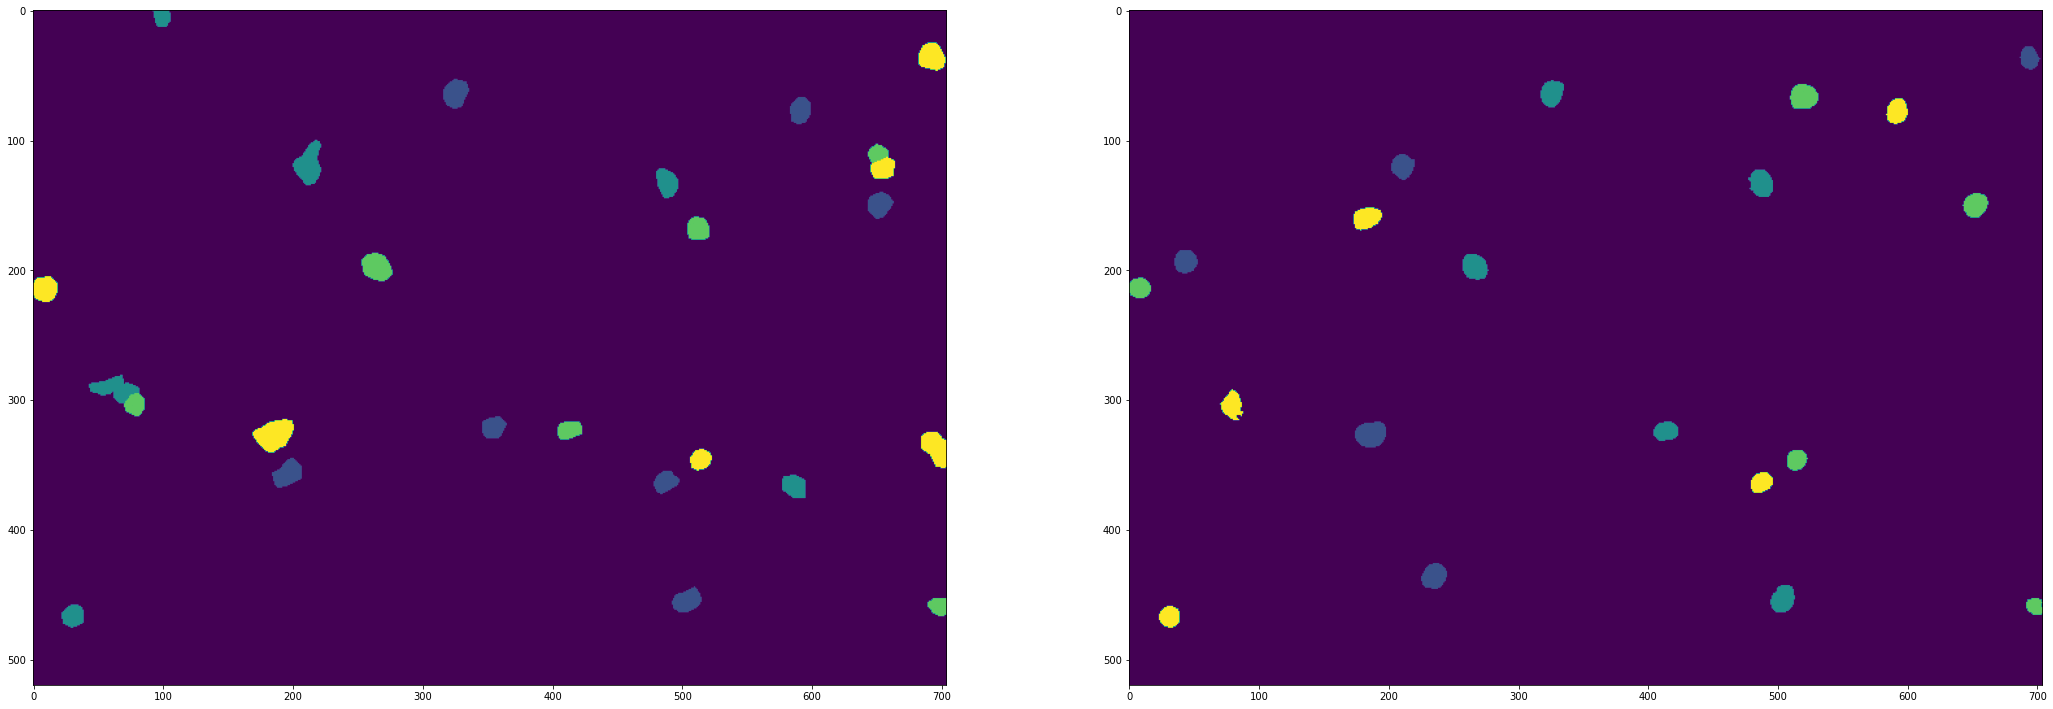

0a6ecc5fe78a


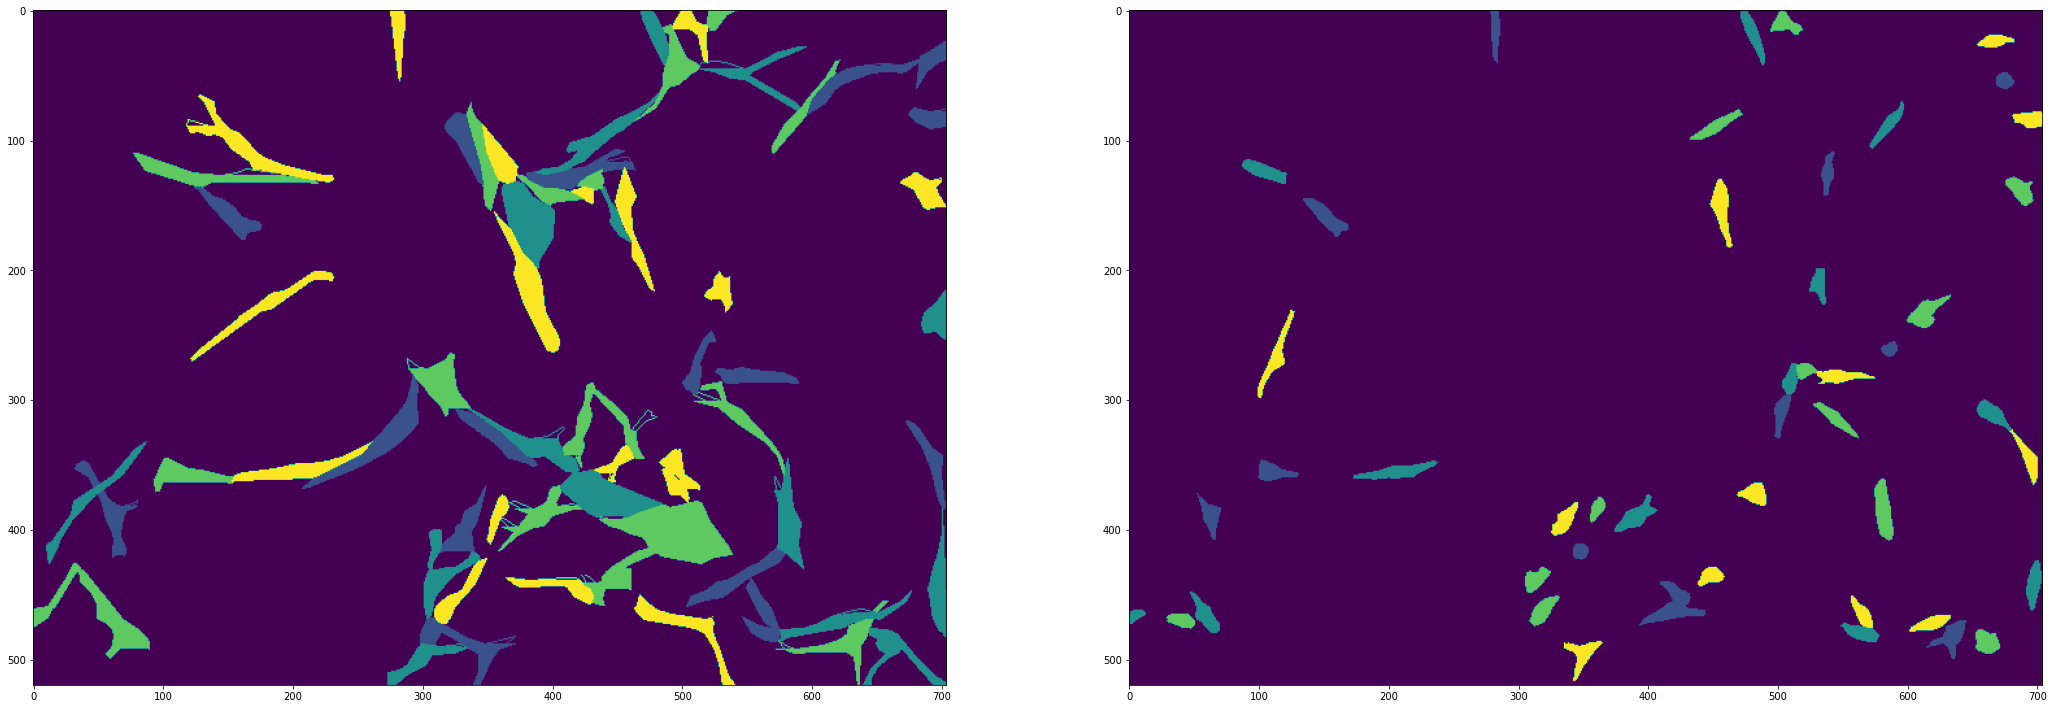

In [23]:
for i,row in df.iterrows():
    
    print(row.id)
    gt_masks = rles_to_mask(row.annotation, shape).astype(np.uint16)
    predicted_masks = rles_to_mask(row.predicted, shape).astype(np.uint16)
    
    gt_masks = (gt_masks>0).astype(int)*(gt_masks%5)
    predicted_masks = (predicted_masks>0).astype(int)*(predicted_masks%5)

    _, axs = plt.subplots(1, 2, figsize=(36, 18))
    axs = axs.flatten()
    axs[0].imshow(gt_masks)
    axs[1].imshow(predicted_masks)
    plt.show()
    
    if i==4: break

## Evaluate

In [55]:
def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

from tqdm.auto import tqdm
def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [
        compute_iou(rles_to_mask(truth,shape), rles_to_mask(pred,shape)) 
            for truth, pred in tqdm(zip(truths, preds))
    ]
    
    if verbose:
        print(ious[0].shape)
        print("Thresh\tTP\tFP\tFN\tPrecision\tRecall")

    prec = []
    recalls = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps)
        r = tps / (tps + fns)
        prec.append(p)
        recalls.append(r)
   
        if verbose:
            print("{:1.2f}\t{}\t{}\t{}\t{:1.3f}\t{:1.3f}".format(t, tps, fps, fns, p, r))

    if verbose:
        print("AP\t-\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return round(np.mean(prec),4)

In [56]:
annotations = df.annotation.values
predictions = df.predicted.values

In [57]:
iou_map(annotations,predictions,verbose=1)

0it [00:00, ?it/s]

<ipython-input-20-f92e87a23207>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(enc, np.float) and np.isnan(enc):


(34, 32)
Thresh	TP	FP	FN	Precision	Recall
0.50	5222	1771	9405	0.747	0.357
0.55	4813	2180	9814	0.688	0.329
0.60	4339	2654	10288	0.620	0.297
0.65	3792	3201	10835	0.542	0.259
0.70	3055	3938	11572	0.437	0.209
0.75	2074	4919	12553	0.297	0.142
0.80	1064	5929	13563	0.152	0.073
0.85	378	6615	14249	0.054	0.026
0.90	39	6954	14588	0.006	0.003
0.95	0	6993	14627	0.000	0.000
AP	-	-	-	-	0.354


0.3543